#### Status: Draft

Let's count the number of .fits files we have

In [1]:
!ls *.fits | wc -l

68



We'll start by importing the libraries and modules we'll need.  

We want astropy to load fits files and matplotlib to show the image.

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

from astropy.stats import sigma_clipped_stats

We'll need to load the file first. We use `open()` function from fits submodule in astropy.  
The returned object has `.info()` method which shows the information about the HDU's contained in the fits file which are like tables or spreadsheet kind of data.

In [3]:
img = fits.open("./ceph_2451890.76992.fits")
img.info()

Filename: ./ceph_2451890.76992.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (201, 201)   int16   


Let's checkout the content of the first(and the only in this case) HDU

In [4]:
ceph_fits = img[0]
data = ceph_fits.data
header = ceph_fits.header

In [5]:
header['DATE-OBS']

'24/01/2001'

These are raw event count for that particular exposure.  

Now, use `imshow()` function from pyplot to plot the image which is in 2-dim matrix shape.

In [6]:
mean, median, std = sigma_clipped_stats(data)

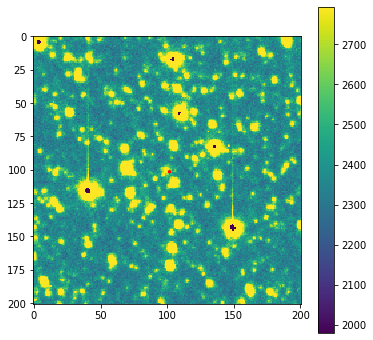

In [7]:
plt.figure(figsize=(6,6))

# set the scale of the image based on its statistics
# any pixel above vmax will show up with the same color as vmax. And vice-versa for vmin
plt.imshow(data, vmin = median - 5*std, vmax = median + 5*std, cmap='viridis')
plt.colorbar()
plt.scatter(101,101, marker="*", c='r', s=8)

Let's now examine the periodic behaviour of the central pixel where our cepheid lies. 

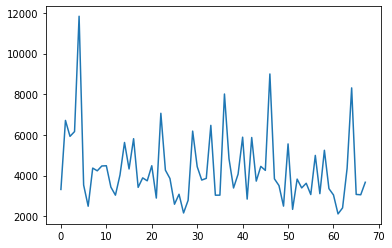

In [8]:
from pathlib import Path
p = Path('./')
curve = []
for file in p.iterdir():
    if file.suffix != '.fits': continue
    img = fits.open(file)
    curve.append(img[0].data[101,101])
    
curve

plt.plot(curve)

That looks somewhat periodic, but definitely not as much as we'd expect.

We haven't introduced the date into the picture yet. It could be that the `.iterfiles()` method we used, doesn't iterate in sorted order.  

So, let's read the juilan date from the file and use it along x-axis. 

Also, let's introduce an aperture size. A single pixel might suffer from statistical noise.

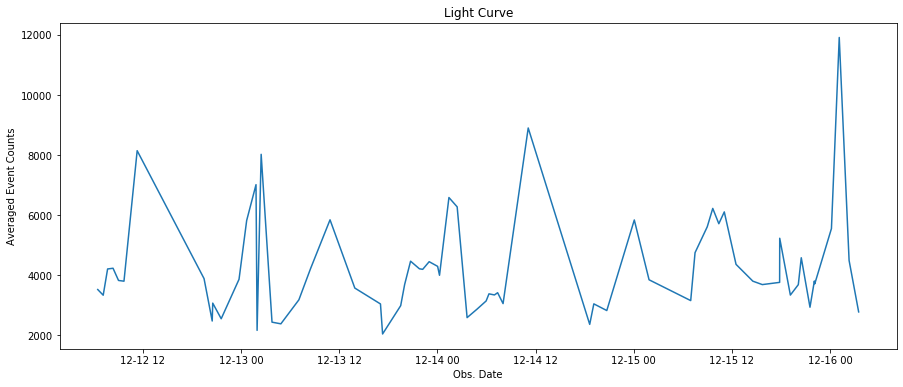

In [12]:
curve = []
a = 1 # square aperture of side 2a+1 is used
for file in p.iterdir():
    if file.suffix != '.fits': continue
    hdulist = fits.open(file)
    img_arr = hdulist[0].data
    mean_count = img_arr[101-a:102+a,101-a:102+a].mean()
    curve.append([str(file)[5:18], mean_count])
    
# We'll need a few more libraries
import numpy as np
import pandas as pd
import julian

curve = np.array(curve, dtype="float")
df = pd.DataFrame(curve, columns=['date', 'mcount'])
df = df.sort_values('date')
df['dtime'] = df.date.map(julian.from_jd)

fig = plt.figure(0, [15, 6])
ax = fig.add_subplot()
ax.plot(df.dtime, df.mcount)
_ = ax.set(title="Light Curve",
           xlabel="Obs. Date", 
           ylabel="Averaged Event Counts")

Let's use a circular aperture instead of a square one. We'll write a function to generate circular filters

In [13]:
def get_circular_aperture(img, x, y, r):
    """Circular filter of size img.shape centered at
    x,y and of radius r (It's too slow, though)
    Inputs: img  -- array like
            x, y -- int (center)
            r    -- int (radius)
    Returns: filter -- array like of same shape as img"""
    
    filter = np.zeros(img.shape)
    len = filter.shape[0]
    for i in range(len):
        for j in range(len):
            if ((i-x)**2 + (j-y)**2 < r):
                filter[i][j] = 1
    return filter

filter = get_circular_aperture(data, 101, 101, 10)
print(filter[95:107, 95:107])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


That works like we expect. Let's use it to get a filter and convolve it with the image.

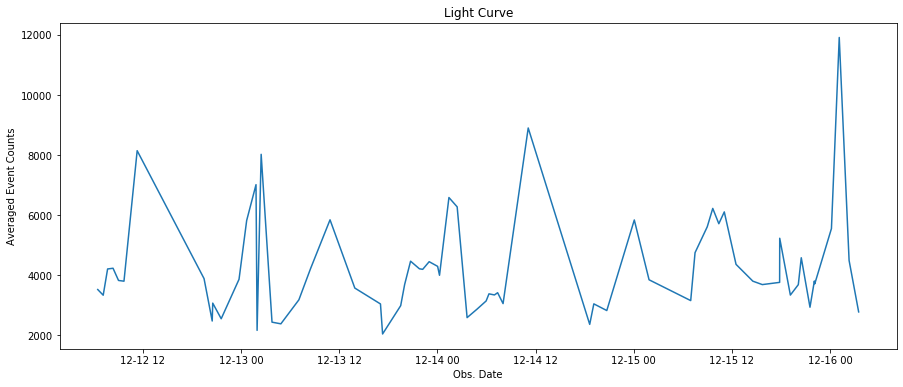

In [15]:
curve = []
a = 3 # circular aperture of radius 5
filter = get_circular_aperture(img_arr, 101, 101, a)

for file in p.iterdir():
    if file.suffix != '.fits': continue
    hdulist = fits.open(file)
    img_arr = hdulist[0].data
    mean_count =  img_arr.ravel().dot(filter.ravel()) / filter.sum()
    curve.append([str(file)[5:18], mean_count])

curve = np.array(curve, dtype="float")
df = pd.DataFrame(curve, columns=['date', 'mcount'])
df = df.sort_values('date')
df['dtime'] = df.date.map(julian.from_jd)

fig = plt.figure(0, [15, 6])
ax = fig.add_subplot()
ax.plot(df.dtime, df.mcount)
_ = ax.set(title="Light Curve",
           xlabel="Obs. Date", 
           ylabel="Averaged Event Counts")

That didn't change it very much.

Let's actually see the picture after we set the apperture and see which one is right by visually inspecting it.

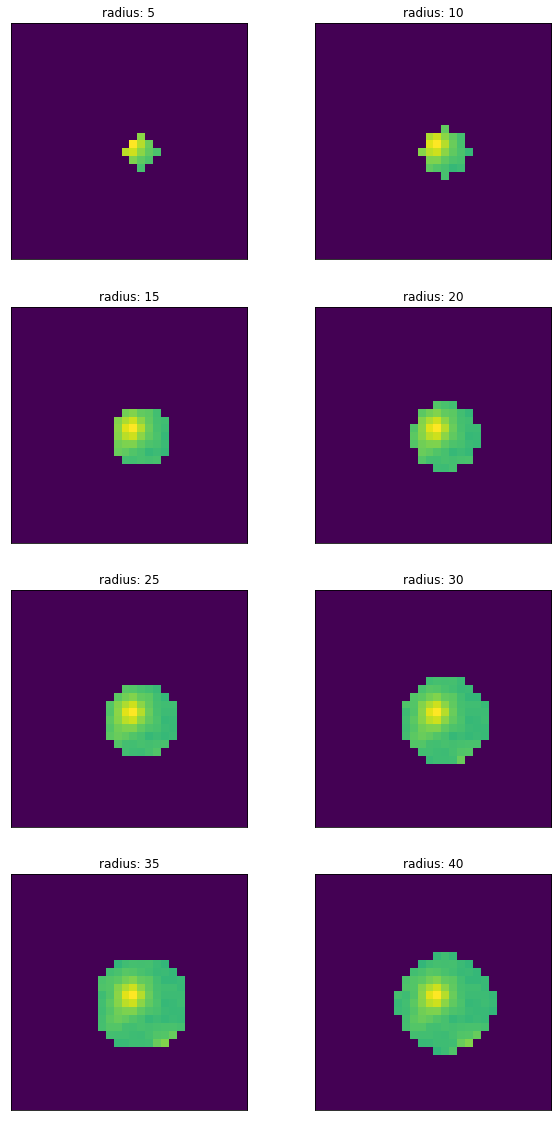

In [19]:
fig = plt.figure(0, [10, 20])
for a in range(5, 41, 5):
    ax = fig.add_subplot(4,2, a/5)
    filter = get_circular_aperture(arr, 101, 101, a)
    filtered =  np.multiply(arr, filter)
    ax.imshow(filtered[85:115,85:115], cmap="viridis")
    ax.set(xticks=[], yticks=[], title=f"radius: {a}")

We can see that a radius of 15 almost fully covers the target. But We notice that the object is getting slightly off the center. Maybe it misses the ceter entirely in some other frame.

let's check for a couple of images with a = 15.

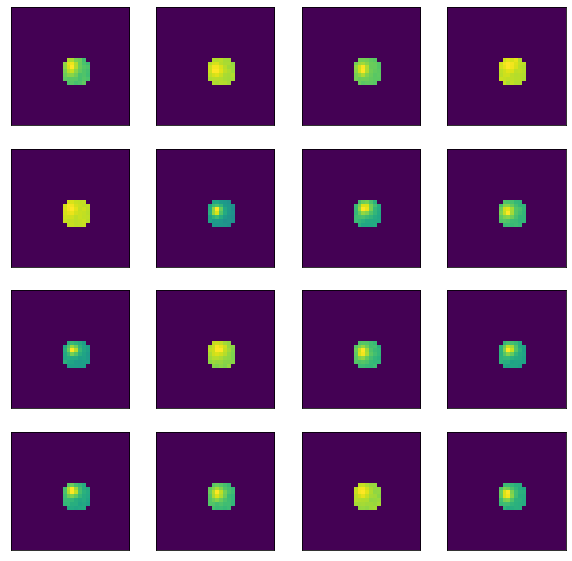

In [22]:
fig = plt.figure(0, [10, 10])
filter = get_circular_aperture(arr, 101, 101, 15)
i = 0

for file in p.iterdir():
    i += 1
    if file.suffix != '.fits': continue
    if i == 17: break
    hdulist = fits.open(file)
    img_arr = hdulist[0].data
    filtered =  np.multiply(img_arr, filter)
    ax = fig.add_subplot(4,4, i)
    ax.imshow(filtered[85:115,85:115], cmap="viridis")
    ax.set(xticks=[], yticks=[])

So, it looks like the cepheid gets bright enough to cover the entire field of view. The target seems to be always inside the aperture and no other sources come into it which is good. 

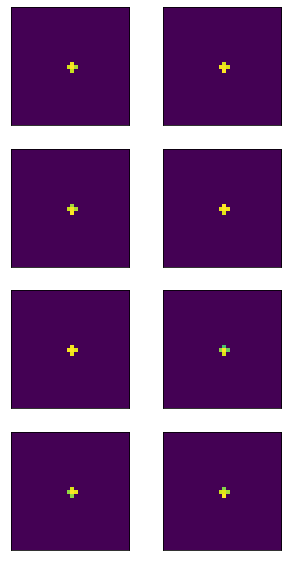

In [18]:
fig = plt.figure(0, [5, 10])
filter = get_circular_aperture(arr, 100, 100, 2)
i = 0

for file in p.iterdir():
    i += 1
    if file.suffix != '.fits': continue
    if i == 9: break
    hdulist = fits.open(file)
    img_arr = hdulist[0].data
    filtered =  np.multiply(img_arr, filter)
    ax = fig.add_subplot(4,2, i)
    ax.imshow(filtered[85:115,85:115], cmap="viridis")
    ax.set(xticks=[], yticks=[])

We changed center to (100, 100) and aperture size to 10. I'd like to have this done automatically. But let's move on for now.

One thing to note is that it probably wont matter if the size of aperture is too low to cover the cepheid entirely. 